In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder \
    .appName("YelpDataAnalysis") \
    .getOrCreate()

24/11/24 22:38:01 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/11/24 22:38:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 22:38:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

24/11/24 22:38:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
business_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/business")
checkin_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/checkin")
review_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/review")
tip_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/tip")
user_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/user")


In [ ]:
business_df.createOrReplaceTempView("businesses")
checkin_df.createOrReplaceTempView("checkins")
review_df.createOrReplaceTempView("reviews")
tip_df.createOrReplaceTempView("tips")
user_df.createOrReplaceTempView("users")

In [ ]:
# Filter businesses for Arizona and a specific category
arizona_businesses = spark.sql("""
    SELECT *
    FROM businesses
    WHERE state = 'AZ' AND categories LIKE '%Restaurants%'
""")
arizona_businesses.createOrReplaceTempView("arizona_businesses")

In [ ]:
# Query 1: Most Active Users
spark.sql("""
    SELECT user_id, name, review_count
    FROM users
    ORDER BY review_count DESC
    LIMIT 10
""").show()

+--------------------+--------+------------+
|             user_id|    name|review_count|
+--------------------+--------+------------+
|Hi10sGSZNxQH3NLyW...|     Fox|       17473|
|8k3aO-mPeyhbR5HUu...|  Victor|       16978|
|hWDybu_KvYLSdEFzG...|   Bruce|       16567|
|RtGqdDBvvBCjcu5dU...|   Shila|       12868|
|P5bUL3Engv-2z6kKo...|     Kim|        9941|
|nmdkHL2JKFx55T3nq...|  Nijole|        8363|
|bQCHF5rn5lMI9c5kE...| Vincent|        8354|
|8RcEwGrFIgkt9WQ35...|  George|        7738|
|Xwnf20FKuikiHcSpc...| Kenneth|        6766|
|CxDOIDnH8gp9KXzpB...|Jennifer|        6679|
+--------------------+--------+------------+



In [ ]:
# Query 2: Elite Users Count
spark.sql("""
    SELECT COUNT(user_id) AS elite_user_count
    FROM users
    WHERE elite IS NOT NULL AND elite != ''
""").show()

+----------------+
|elite_user_count|
+----------------+
|           91198|
+----------------+



In [ ]:
# Query 3: Average Stars by User
spark.sql("""
    SELECT user_id, name, ROUND(AVG(average_stars), 2) AS avg_stars
    FROM users
    GROUP BY user_id, name
    ORDER BY avg_stars DESC
    LIMIT 10
""").show()

+--------------------+-------+---------+
|             user_id|   name|avg_stars|
+--------------------+-------+---------+
|p1kDN06Ua2_Kg1Z5A...|  David|      5.0|
|RRVdAFUhXrXwRQ8jl...|   Shea|      5.0|
|j0LuHM1ifpQht68gJ...|Patrick|      5.0|
|ox8mzdJtA0qGAf6HS...|    Amy|      5.0|
|tXk8i7eAONWdx4puL...|   Sita|      5.0|
|RbNNvwjLC5B6fF_di...| Tourne|      5.0|
|A_HprLEwh5z12tI3u...|   Cate|      5.0|
|YUgEpD9lU7VAm_YdB...| Joshua|      5.0|
|cmFt4xyHRAB0LMgpJ...|    Guy|      5.0|
|Viy8jBzC6TZtPCJMf...|Michael|      5.0|
+--------------------+-------+---------+



In [ ]:
# Query 4: Users Receiving Most Compliments
spark.sql("""
    SELECT user_id, name, (compliment_funny + compliment_cool + compliment_plain) AS total_compliments
    FROM users
    ORDER BY total_compliments DESC
    LIMIT 10
""").show()

+--------------------+--------+-----------------+
|             user_id|    name|total_compliments|
+--------------------+--------+-----------------+
|JjXuiru1_ONzDkYVr...| Richard|           201031|
|Tqm7Wu7IBJ1td3Ab5...|   Brian|            84959|
|ax7SnXOTIpatbsmqH...|  Rohlin|            82241|
|--2vR0DIsmQ6WfcSz...|  Harald|            71212|
|NOUfyJW-BAo_-Cbfo...|   Lolia|            61171|
|Ggx8iUdJ7lsQSqXRu...|  Nadine|            53158|
|Kf5PVQUdDvQYf-MXo...|Marianne|            51357|
|HH7iiWvBqV-20lA7J...|    Lyla|            51049|
|8wKZ9gJYJtTdSVWgW...|    John|            50962|
|_cpU0VVdQcfN5AnuL...|   Paige|            50125|
+--------------------+--------+-----------------+



In [ ]:
# Query 5: Top Contributors by Business Category
spark.sql("""
    SELECT r.user_id, u.name, COUNT(r.review_id) AS total_reviews
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    JOIN arizona_businesses b ON r.business_id = b.business_id
    GROUP BY r.user_id, u.name
    ORDER BY total_reviews DESC
    LIMIT 10
""").show()

24/11/24 22:30:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+--------+-------------+
|             user_id|    name|total_reviews|
+--------------------+--------+-------------+
|6ObFF8-uKnOAlXuSH...|Isabella|          399|
|I06gY9An4o81XpejL...|    Bill|          389|
|2YKkLFeOx-0zRcWp0...|    Mark|          378|
|9Y1YkloHk2MAE3hkw...|    Gene|          321|
|W67nXodRWTIa-d1NJ...|    Saba|          313|
|EAHCCgMFoJxlOPcCP...|     Kim|          296|
|dvu83QWKsnnbGvNVQ...| William|          280|
|fdFgZQQYQJeEAshH4...|    Brad|          262|
|ABaDXhzUa0UFFB9YS...|    Mike|          252|
|VFp9AYShu_C9T4QsH...|     Jen|          246|
+--------------------+--------+-------------+



In [ ]:
# Query 6: User User Influence by Average Business Rating

spark.sql("""
SELECT u.user_id, u.name, ROUND(AVG(u.average_stars), 2) AS user_avg_stars, ROUND(AVG(b.stars), 2) AS business_avg_stars
FROM reviews r
JOIN users u ON r.user_id = u.user_id
JOIN arizona_businesses b ON r.business_id = b.business_id
GROUP BY u.user_id, u.name
ORDER BY user_avg_stars DESC
LIMIT 10

""").show()

24/11/24 22:30:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:30:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+--------+--------------+------------------+
|             user_id|    name|user_avg_stars|business_avg_stars|
+--------------------+--------+--------------+------------------+
|-D3_-orFYezTdpV8h...|    Rich|           5.0|               4.0|
|-bHH8d10D_9SLxYRl...|Jonathan|           5.0|               4.5|
|-DrN_XfNI5_ewrqLn...|   Manny|           5.0|              3.75|
|-mV3r3hXBn4Fppvzx...| Melinda|           5.0|              4.25|
|3lJ-tFiwswekw7HZu...|  Steven|           5.0|               4.0|
|-du0nYJf8Y3-gvj8M...|   Peter|           5.0|               3.5|
|-Dun57fYL0QdAKJKd...|   Sogol|           5.0|               2.5|
|-0FDPC6mDeA5k0gR3...|    Eric|           5.0|               3.0|
|-ALx8GQw1_4Vbbyy1...|  Ashley|           5.0|               4.0|
|-erRF2Sn7w4m3hdnt...| Richard|           5.0|               3.5|
+--------------------+--------+--------------+------------------+



In [ ]:
# Query 7: Review Trends by Elite Status
spark.sql("""
    SELECT u.elite, ROUND(AVG(r.stars), 2) AS avg_rating
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    GROUP BY u.elite
    ORDER BY avg_rating DESC
""").show()

24/11/24 22:31:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:31:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:31:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:31:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+----------+
|               elite|avg_rating|
+--------------------+----------+
|2009,2010,2011,20...|       5.0|
|2011,2012,2014,20...|       5.0|
|2010,2011,2015,20...|       5.0|
| 2011,2014,2015,2021|       5.0|
|2009,2010,2011,20...|       5.0|
|           2013,2021|       5.0|
|2008,2009,2010,20...|       5.0|
|2011,2012,2013,20...|       5.0|
|2006,2007,2008,20...|       5.0|
|2010,2011,2013,20...|       5.0|
|2009,2010,2012,20...|       5.0|
|2006,2007,2008,20...|       5.0|
|      2006,2007,2019|       5.0|
| 2013,2014,2018,2019|       5.0|
|2012,2013,2015,20...|       5.0|
|2006,2012,2013,20...|       5.0|
|2008,2009,2010,20...|       5.0|
|2007,2009,2010,20...|       5.0|
|2011,2012,2013,20...|       5.0|
|2006,2007,2008,20...|       5.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
# Query 8: Tip Analysis
spark.sql("""
    SELECT t.user_id, u.name, COUNT(t.compliment_count) AS tip_count
    FROM tips t
    JOIN users u ON t.user_id = u.user_id
    GROUP BY t.user_id, u.name
    ORDER BY tip_count DESC
    LIMIT 10
""").show()

+--------------------+-------+---------+
|             user_id|   name|tip_count|
+--------------------+-------+---------+
|fCvMnJU1Z-XhAjKg9...|Michael|     4071|
|5Y5KbsI5buMcNh2hT...| Marcia|     1385|
|lMY8NBPyzlPbbu-KB...|Christy|     1373|
|Rr4cLb6Go91FT134o...|    Gem|     1230|
|qjfMBIZpQT9DDtw_B...| Rachel|     1230|
|-G7Zkl1wIWBBmD0KR...| Gerald|     1035|
|sraTrYU-7q_bQ0TxQ...|  Brian|      902|
|I2XpWCHAom1JRyHXZ...|  Kathy|      821|
|xWmYN57XXZbg0LOK8...|   John|      813|
|zYFGMy1_thjMnvQLX...|  Wanda|      782|
+--------------------+-------+---------+



In [ ]:
# Query 9: User Influence on Business Ratings
spark.sql("""
    SELECT u.user_id, u.name, ROUND(AVG(u.average_stars), 2) AS user_avg_stars, ROUND(AVG(b.stars), 2) AS business_avg_stars
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    JOIN arizona_businesses b ON r.business_id = b.business_id
    GROUP BY u.user_id, u.name
    ORDER BY user_avg_stars DESC
    LIMIT 10
""").show()

24/11/24 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+--------+--------------+------------------+
|             user_id|    name|user_avg_stars|business_avg_stars|
+--------------------+--------+--------------+------------------+
|-4Q12LCaWlRi2lMoC...|    Pete|           5.0|               3.0|
|-bHH8d10D_9SLxYRl...|Jonathan|           5.0|               4.5|
|-DrN_XfNI5_ewrqLn...|   Manny|           5.0|              3.75|
|-mV3r3hXBn4Fppvzx...| Melinda|           5.0|              4.25|
|3lJ-tFiwswekw7HZu...|  Steven|           5.0|               4.0|
|-du0nYJf8Y3-gvj8M...|   Peter|           5.0|               3.5|
|-Dun57fYL0QdAKJKd...|   Sogol|           5.0|               2.5|
|-0FDPC6mDeA5k0gR3...|    Eric|           5.0|               3.0|
|-DKDfXgMRmQHY9eL9...|  Robert|           5.0|               3.5|
|-erRF2Sn7w4m3hdnt...| Richard|           5.0|               3.5|
+--------------------+--------+--------------+------------------+



In [ ]:
# Query 10: Review Trends Over Time by User Activity
spark.sql("""SELECT u.user_id, u.name, YEAR(r.date) AS review_year, COUNT(r.review_id) AS total_reviews
FROM reviews r
JOIN users u ON r.user_id = u.user_id
WHERE u.review_count > 100
GROUP BY u.user_id, u.name, YEAR(r.date)
ORDER BY review_year ASC, total_reviews DESC
LIMIT 10""").show()



+--------------------+-------+-----------+-------------+
|             user_id|   name|review_year|total_reviews|
+--------------------+-------+-----------+-------------+
|n-lBS02-3yvlY5Q91...|Zachary|       2005|          171|
|3MYdpmHeNwC6FquRW...|   Andy|       2005|           60|
|iUeZhkI0OK0BisakO...|patrick|       2005|           51|
|_BHTC7nyCBoZcfiiD...|Gourmet|       2005|           37|
|jTXj5uf5ER5siDnQK...|  Keith|       2005|           24|
|3xX-Et9I4Bi4wdRPW...|   Hans|       2005|           19|
|DOFamdMaC_hjn9zg3...|    Dan|       2005|           16|
|H4JNrBAoyCk_ZMZWb...|Allison|       2005|           14|
|AuXICYKDCopDrvjy7...|Michael|       2005|           12|
|c8qFkI_VusWo0xZvk...|matthew|       2005|           11|
+--------------------+-------+-----------+-------------+



In [ ]:
import matplotlib.pyplot as plt

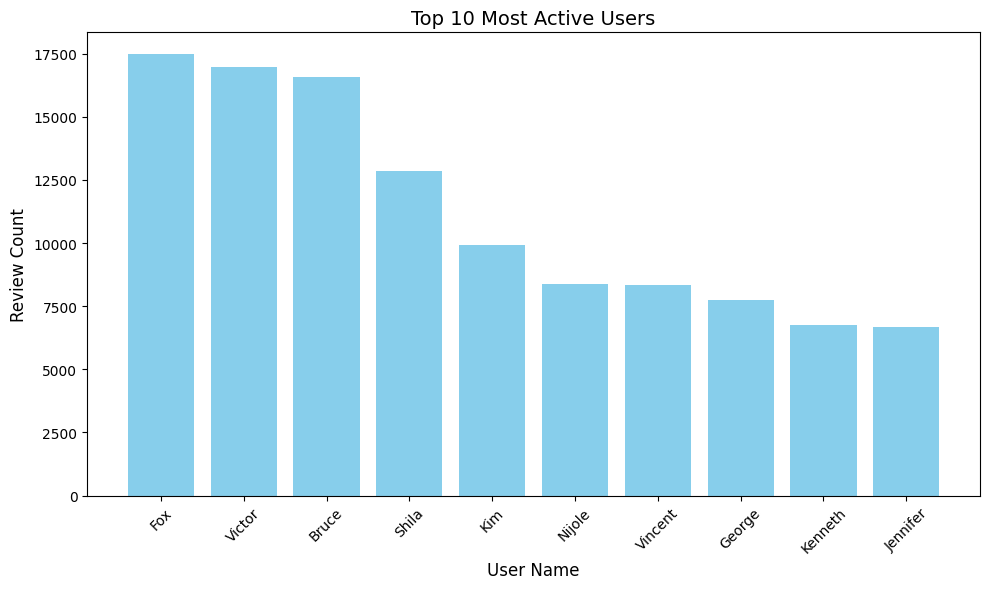

In [ ]:
# Visualisation for Query 1
most_active_users = spark.sql("""
    SELECT user_id, name, review_count
    FROM users
    ORDER BY review_count DESC
    LIMIT 10
""").toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(most_active_users["name"], most_active_users["review_count"], color="skyblue")
plt.xlabel("User Name", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.title("Top 10 Most Active Users", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


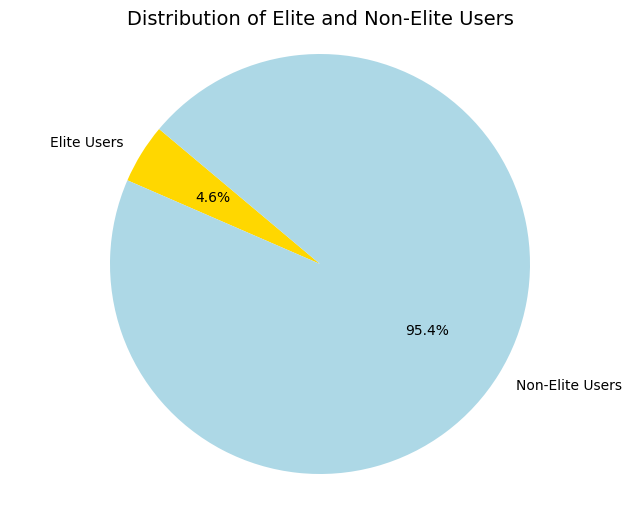

In [ ]:
# Visualization of Query 2
elite_users_count = spark.sql("""
    SELECT COUNT(user_id) AS elite_user_count
    FROM users
    WHERE elite IS NOT NULL AND elite != ''
""").collect()[0]["elite_user_count"]

non_elite_users_count = spark.sql("""
    SELECT COUNT(user_id) AS non_elite_user_count
    FROM users
    WHERE elite IS NULL OR elite = ''
""").collect()[0]["non_elite_user_count"]

# Pie Chart
labels = ["Elite Users", "Non-Elite Users"]
sizes = [elite_users_count, non_elite_users_count]
colors = ["gold", "lightblue"]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Distribution of Elite and Non-Elite Users", fontsize=14)
plt.axis("equal")
plt.show()

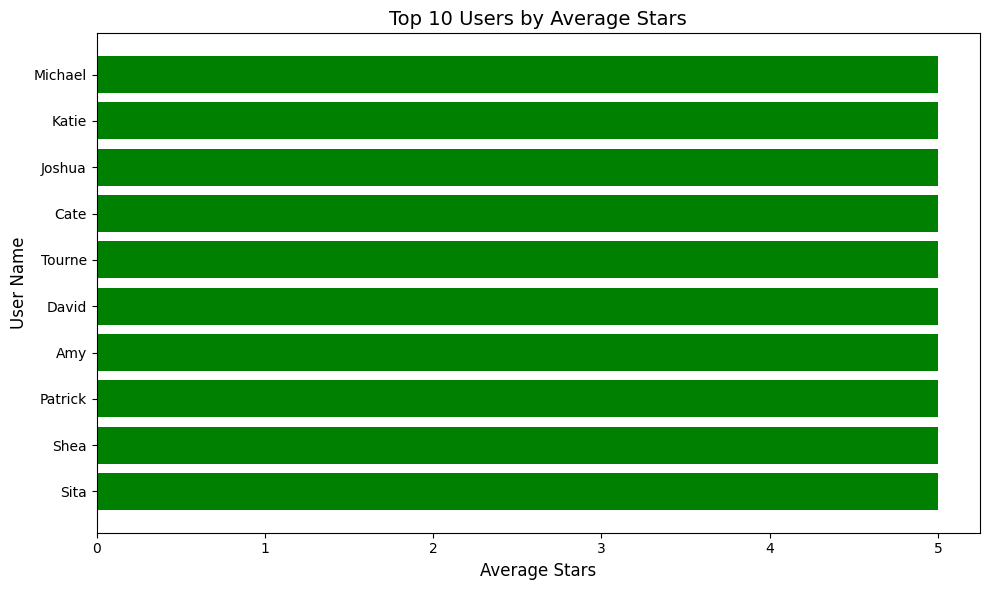

In [ ]:
# Visualisation of Query 3
avg_stars_by_user = spark.sql("""
    SELECT user_id, name, ROUND(AVG(average_stars), 2) AS avg_stars
    FROM users
    GROUP BY user_id, name
    ORDER BY avg_stars DESC
    LIMIT 10
""").toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(avg_stars_by_user["name"], avg_stars_by_user["avg_stars"], color="green")
plt.xlabel("Average Stars", fontsize=12)
plt.ylabel("User Name", fontsize=12)
plt.title("Top 10 Users by Average Stars", fontsize=14)
plt.tight_layout()
plt.show()


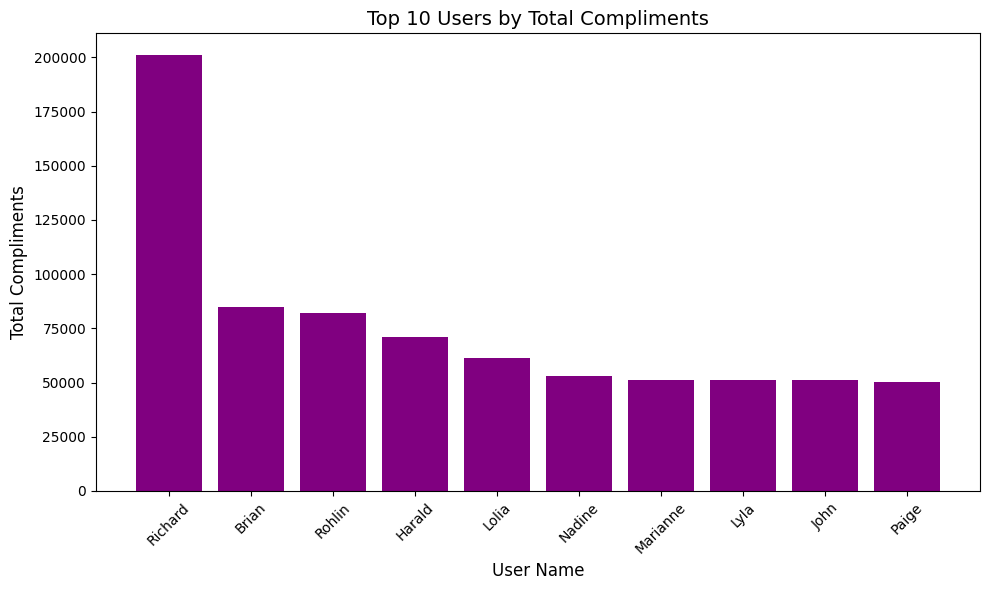

In [ ]:
#Visualization of Query 4
most_compliments = spark.sql("""
    SELECT user_id, name, (compliment_funny + compliment_cool + compliment_plain) AS total_compliments
    FROM users
    ORDER BY total_compliments DESC
    LIMIT 10
""").toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(most_compliments["name"], most_compliments["total_compliments"], color="purple")
plt.xlabel("User Name", fontsize=12)
plt.ylabel("Total Compliments", fontsize=12)
plt.title("Top 10 Users by Total Compliments", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


24/11/24 22:42:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:42:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:42:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:42:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:42:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:42:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:42:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:42:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


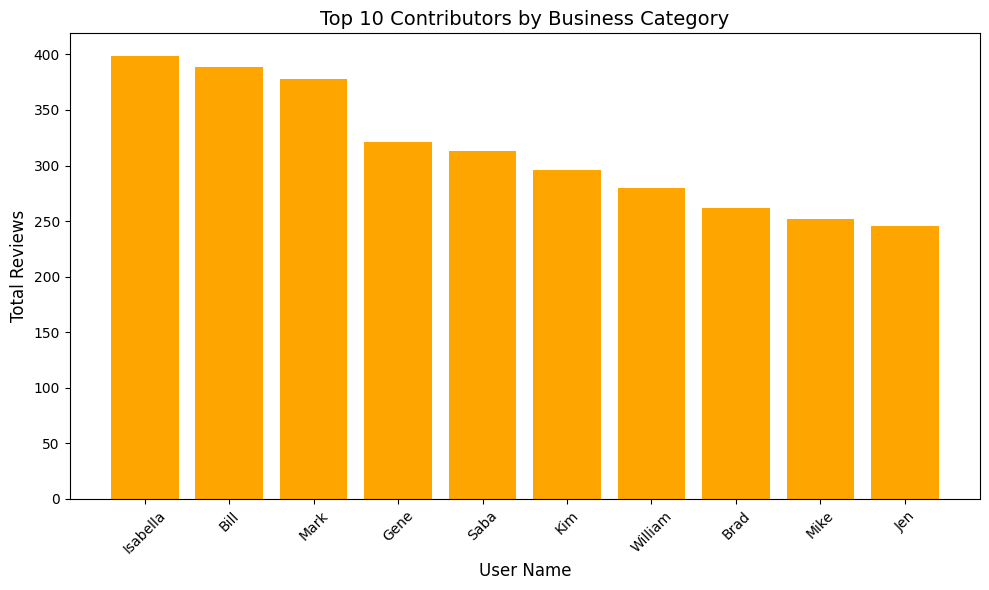

In [ ]:
# Visualization Of Query 5
top_contributors = spark.sql("""
    SELECT r.user_id, u.name, COUNT(r.review_id) AS total_reviews
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    JOIN arizona_businesses b ON r.business_id = b.business_id
    GROUP BY r.user_id, u.name
    ORDER BY total_reviews DESC
    LIMIT 10
""").toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_contributors["name"], top_contributors["total_reviews"], color="orange")
plt.xlabel("User Name", fontsize=12)
plt.ylabel("Total Reviews", fontsize=12)
plt.title("Top 10 Contributors by Business Category", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


24/11/24 22:44:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:44:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:44:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:44:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


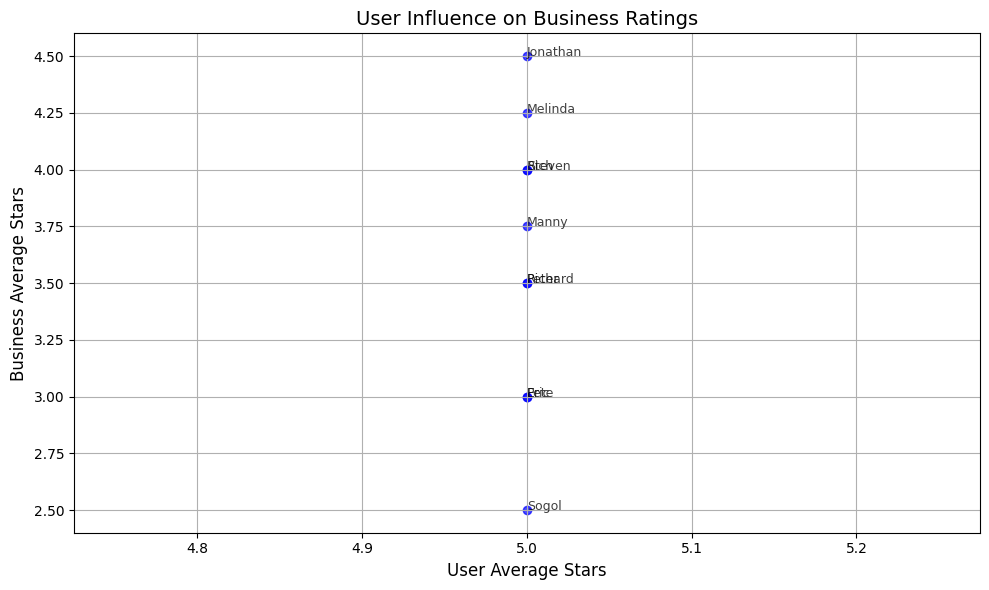

In [ ]:
#Visualization for Query 6
# Convert SQL results to Pandas DataFrame
user_influence_df = spark.sql("""
    SELECT u.user_id, u.name, ROUND(AVG(u.average_stars), 2) AS user_avg_stars, ROUND(AVG(b.stars), 2) AS business_avg_stars
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    JOIN arizona_businesses b ON r.business_id = b.business_id
    GROUP BY u.user_id, u.name
    ORDER BY user_avg_stars DESC
    LIMIT 10
""").toPandas()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(user_influence_df['user_avg_stars'], user_influence_df['business_avg_stars'], color='blue', alpha=0.7)

# Add labels and title
plt.xlabel("User Average Stars", fontsize=12)
plt.ylabel("Business Average Stars", fontsize=12)
plt.title("User Influence on Business Ratings", fontsize=14)
plt.grid(True)

# Annotate points with user names
for i, row in user_influence_df.iterrows():
    plt.text(row['user_avg_stars'], row['business_avg_stars'], row['name'], fontsize=9, alpha=0.75)

# Show the plot
plt.tight_layout()
plt.show()


24/11/24 22:52:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:52:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:52:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:52:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


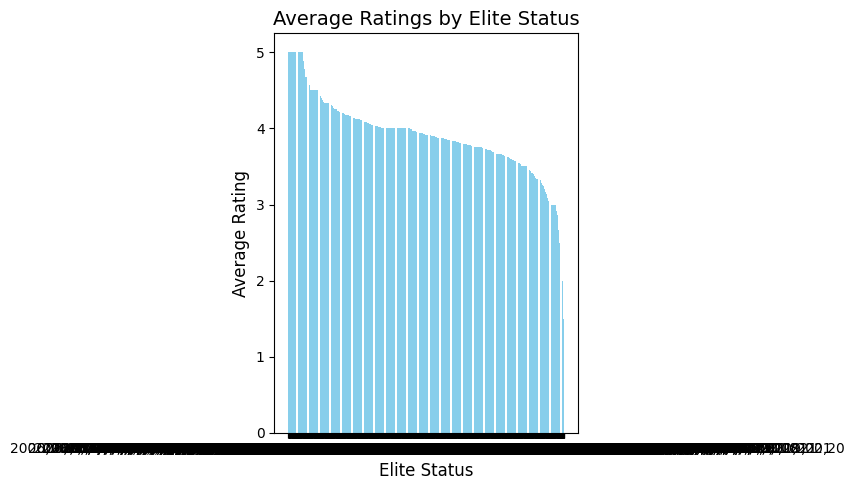

In [ ]:
# Visualization for Query 7
elite_review_trends = spark.sql("""
    SELECT u.elite, ROUND(AVG(r.stars), 2) AS avg_rating
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    GROUP BY u.elite
    ORDER BY avg_rating DESC
""").toPandas()

plt.figure(figsize=(8, 5))
plt.bar(elite_review_trends["elite"].fillna("Non-Elite"), elite_review_trends["avg_rating"], color="skyblue")


plt.xlabel("Elite Status", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.title("Average Ratings by Elite Status", fontsize=14)


plt.tight_layout()
plt.show()


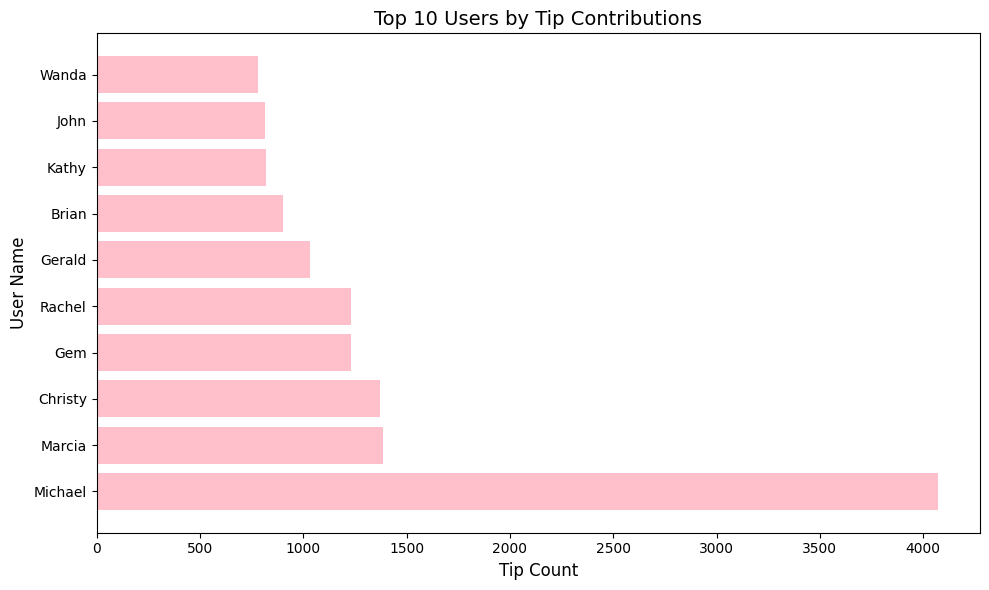

In [ ]:
# Visualization for Query 8
top_tip_contributors = spark.sql("""
    SELECT t.user_id, u.name, COUNT(t.compliment_count) AS tip_count
    FROM tips t
    JOIN users u ON t.user_id = u.user_id
    GROUP BY t.user_id, u.name
    ORDER BY tip_count DESC
    LIMIT 10
""").toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_tip_contributors["name"], top_tip_contributors["tip_count"], color="pink")
plt.xlabel("Tip Count", fontsize=12)
plt.ylabel("User Name", fontsize=12)
plt.title("Top 10 Users by Tip Contributions", fontsize=14)
plt.tight_layout()
plt.show()


24/11/24 22:48:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:48:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:48:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 22:48:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


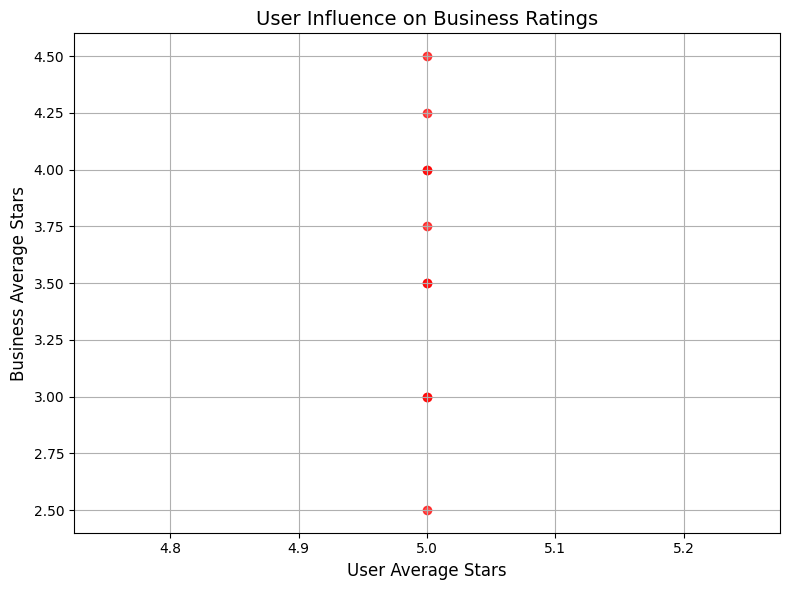

In [ ]:
# Visualization for Query 9
user_business_influence = spark.sql("""
    SELECT u.user_id, u.name, ROUND(AVG(u.average_stars), 2) AS user_avg_stars, ROUND(AVG(b.stars), 2) AS business_avg_stars
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    JOIN arizona_businesses b ON r.business_id = b.business_id
    GROUP BY u.user_id, u.name
    ORDER BY user_avg_stars DESC
    LIMIT 10
""").toPandas()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(user_business_influence["user_avg_stars"], user_business_influence["business_avg_stars"], color="red", alpha=0.7)
plt.xlabel("User Average Stars", fontsize=12)
plt.ylabel("Business Average Stars", fontsize=12)
plt.title("User Influence on Business Ratings", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


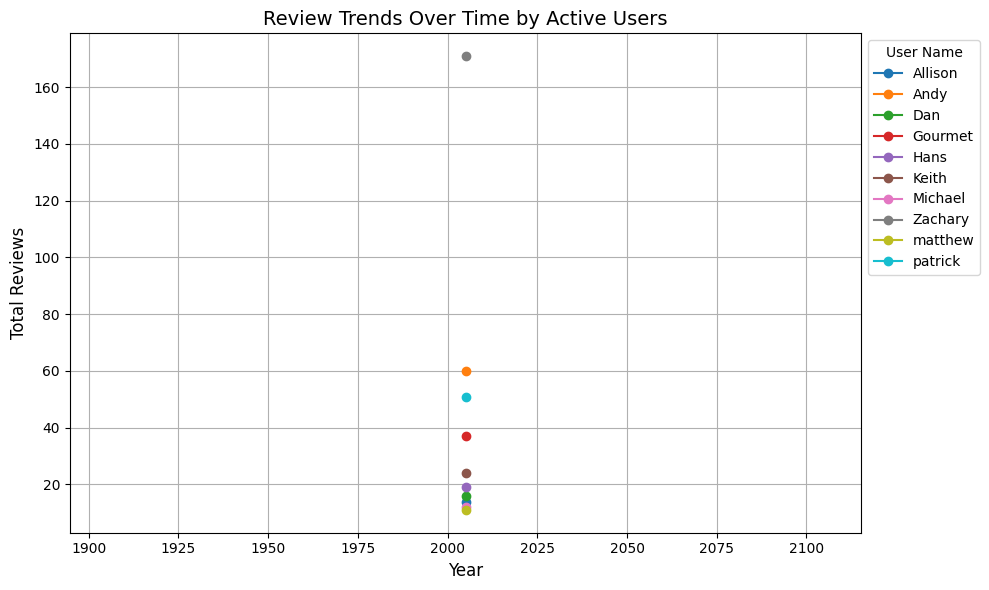

In [ ]:
# Visualization for Query 10
import matplotlib.pyplot as plt

# Convert SQL result to Pandas DataFrame
review_trends_df = spark.sql("""
    SELECT u.user_id, u.name, YEAR(r.date) AS review_year, COUNT(r.review_id) AS total_reviews
    FROM reviews r
    JOIN users u ON r.user_id = u.user_id
    WHERE u.review_count > 100
    GROUP BY u.user_id, u.name, YEAR(r.date)
    ORDER BY review_year ASC, total_reviews DESC
    LIMIT 10
""").toPandas()

# Create a pivot table for better visualization
pivot_df = review_trends_df.pivot(index="review_year", columns="name", values="total_reviews")

# Plotting
plt.figure(figsize=(10, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], marker="o", label=column)

# Add labels, title, and legend
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Reviews", fontsize=12)
plt.title("Review Trends Over Time by Active Users", fontsize=14)
plt.legend(title="User Name", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)

plt.tight_layout()
plt.show()

